In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from mlxtend.data import loadlocal_mnist

In [2]:
def process_mnist_data() -> (np.ndarray, np.ndarray, np.ndarray, np.ndarray):
    mnist_path = './MNIST/'
    train_images, train_labels = loadlocal_mnist(
        images_path = mnist_path + './train-images.idx3-ubyte',
        labels_path = mnist_path + './train-labels.idx1-ubyte'
    )
    test_images, test_labels = loadlocal_mnist(
        images_path = mnist_path + './t10k-images.idx3-ubyte',
        labels_path = mnist_path + './t10k-labels.idx1-ubyte'
    )
    return train_images, train_labels, test_images, test_labels

In [3]:
def unpickle(file):
    with open(file, 'rb') as fo:
        data_dict = pickle.load(fo, encoding='bytes')
    return data_dict

In [4]:
def process_cifar_dataset() -> (np.ndarray, np.ndarray, np.ndarray, np.ndarray):
    cifar_path = './cifar-10-python/cifar-10-batches-py'
    data_batch = unpickle(cifar_path + '/data_batch_1')
    train_images, train_labels = data_batch[b'data'], np.array(data_batch[b'labels'])
    for i in range(2,6):
        data_batch = unpickle(cifar_path + '/data_batch_' + str(i))
        train_images = np.concatenate((train_images, data_batch[b'data']), axis=0)
        train_labels = np.concatenate((train_labels, np.array(data_batch[b'labels'])), axis=0)
    test_batch = unpickle(cifar_path + '/test_batch')
    test_images, test_labels = test_batch[b'data'], np.array(test_batch[b'labels'])
    return train_images, train_labels, test_images, test_labels

In [5]:
def process_toy_dataset():
    toy_dataset_path = './Toy Dataset/'

In [6]:
def relu(matrix:np.ndarray) -> np.ndarray:
    return matrix * (matrix > 0)

In [7]:
class ConvolutionLayer:
    def __init__(self, output_channel_count: int, filter_dimension: int, stride: int, padding: int):
        self.output_channel_count = output_channel_count
        self.filter_dimension = filter_dimension
        self.stride = stride
        self.padding = padding

    def forward(self, input_image: np.ndarray) -> np.ndarray:
        input_dimentions = input_image.shape[0]
        output_dimentions = (input_dimentions - self.filter_dimension + 2 * self.padding) // self.stride + 1
        input_shape = input_image.shape

        filters = np.random.rand(
            self.output_channel_count,
            self.filter_dimension,
            self.filter_dimension,
            input_shape[2]
        )

        bias = np.random.rand(self.output_channel_count)

        # Pad the image
        padded_image = np.zeros((
            input_shape[0]+ 2*self.padding,
            input_shape[1]+ 2*self.padding,
            input_shape[2]
        ))

        # Padding variables
        x_min = self.padding
        x_max = x_min + input_shape[0]
        y_min = self.padding
        y_max = y_min + input_shape[1]

        padded_image[x_min:x_max, y_min:y_max, :] = input_image
        padded_image /= 255.0
        padded_dimensions = padded_image.shape

        output = np.zeros((output_dimentions, output_dimentions, self.output_channel_count))

        for i in range(self.output_channel_count):
            image_y = out_y = 0
            while image_y + self.filter_dimension <= padded_dimensions[1]:
                image_x = out_x = 0
                while image_x + self.filter_dimension <= padded_dimensions[0]:
                    image_slice = padded_image[image_x:image_x+self.filter_dimension, image_y:image_y+self.filter_dimension, :]
                    output[out_x, out_y, i] = np.sum(image_slice * filters[i, :, :, :]) + bias[i]
                    image_x += self.stride
                    out_x += 1
                image_y += self.stride
                out_y += 1

        return output

    def backward(self):
        pass

In [8]:
class ActivationLayer:
    def __init__(self):
        pass

    def forward(self, input_matrix: np.ndarray) -> np.ndarray:
        return relu(input_matrix)

    def backward(self):
        pass

In [9]:
class MaxPoolingLayer:
    def __init__(self, filter_dimension: int, stride: int):
        self.filter_dimension = filter_dimension
        self.stride = stride

    def forward(self, image: np.ndarray) -> np.ndarray:
        input_dimensions = image.shape

        output_dimension = (input_dimensions[0] - self.filter_dimension) // self.stride + 1

        output = np.zeros((output_dimension, output_dimension, input_dimensions[2]))

        image_y = out_y = 0
        while image_y + self.filter_dimension <= input_dimensions[1]:
            image_x = out_x = 0
            while image_x + self.filter_dimension <= input_dimensions[0]:
                image_slice = image[image_x: image_x+self.filter_dimension, image_y: image_y+self.filter_dimension, :]
                output[out_x, out_y, :] = np.max(image_slice, axis=(0, 1))
                image_x += self.stride
                out_x += 1
            image_y += self.stride
            out_y += 1

        return output

    def backward(self):
        pass

In [10]:
class FlatteningLayer:
    def __init__(self):
        pass

    def forward(self, image: np.ndarray) -> np.ndarray:
        return image.flatten().reshape(-1, 1)

    def backward(self):
        pass

In [11]:
class FullyConnectedLayer:
    pass

In [12]:
class SoftmaxLayer:
    pass

(28, 28, 10)


array([[0.62949683, 0.62949683, 0.62949683, 0.62949683, 0.62949683,
        0.62949683, 0.62949683, 0.62949683, 0.62949683, 0.62949683,
        0.62949683, 0.62949683, 0.62949683, 0.62949683, 0.62949683,
        0.62949683, 0.62949683, 0.62949683, 0.62949683, 0.62949683,
        0.62949683, 0.62949683, 0.62949683, 0.62949683, 0.62949683,
        0.62949683, 0.62949683, 0.62949683],
       [0.62949683, 0.62949683, 0.62949683, 0.62949683, 0.62949683,
        0.62949683, 0.62949683, 0.62949683, 0.62949683, 0.62949683,
        0.62949683, 0.62949683, 0.62949683, 0.62949683, 0.62949683,
        0.62949683, 0.62949683, 0.62949683, 0.62949683, 0.62949683,
        0.62949683, 0.62949683, 0.62949683, 0.62949683, 0.62949683,
        0.62949683, 0.62949683, 0.62949683],
       [0.62949683, 0.62949683, 0.62949683, 0.62949683, 0.62949683,
        0.62949683, 0.62949683, 0.62949683, 0.62949683, 0.62949683,
        0.62949683, 0.62949683, 0.62949683, 0.62949683, 0.62949683,
        0.62949683, 0.6294

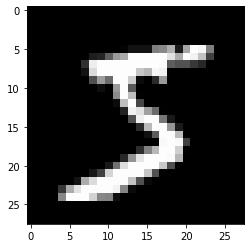

In [13]:
x_train, y_train, x_test, y_test = process_mnist_data()
c = ConvolutionLayer(10, 3, 1, 1)
img = x_train[0].reshape(28, 28, 1)
plt.imshow(img, cmap='gray')
o = c.forward(img)
print(o.shape)
o [:, :, 0]

In [14]:
m = MaxPoolingLayer(2, 2)
o1 = m.forward(o)
o1[:, :, 0]

array([[0.62949683, 0.62949683, 0.62949683, 0.62949683, 0.62949683,
        0.62949683, 0.62949683, 0.62949683, 0.62949683, 0.62949683,
        0.62949683, 0.62949683, 0.62949683, 0.62949683],
       [0.62949683, 0.62949683, 0.62949683, 0.62949683, 0.62949683,
        0.62949683, 0.62949683, 0.62949683, 0.62949683, 0.62949683,
        0.62949683, 0.62949683, 0.62949683, 0.62949683],
       [0.62949683, 0.62949683, 0.62949683, 0.70664413, 0.94283367,
        1.34861996, 1.78077494, 1.97037966, 2.23015024, 2.22770416,
        2.33812915, 2.02390701, 0.96309286, 0.62949683],
       [0.62949683, 0.62949683, 0.62949683, 1.46643196, 2.87719774,
        3.38811959, 3.71181441, 3.95539092, 4.01259041, 2.77510589,
        2.83726986, 2.68705275, 1.16333373, 0.62949683],
       [0.62949683, 0.62949683, 0.62949683, 1.3286371 , 3.3461081 ,
        3.99438883, 3.98534815, 3.01429637, 3.20237105, 2.28176448,
        1.06131882, 0.86195442, 0.62949683, 0.62949683],
       [0.62949683, 0.62949683, 0.6

In [15]:
f = FlatteningLayer()
o2 = f.forward(o1)
o2

array([[0.62949683],
       [0.82506871],
       [0.61674648],
       ...,
       [0.33084907],
       [0.33588899],
       [0.24708561]])

(32, 32, 10)


array([[1.07208829, 1.31624314, 1.28114285, ..., 3.79631922, 3.70923101,
        2.97936817],
       [1.01714897, 1.3861713 , 1.47852527, ..., 4.67500869, 4.51061115,
        3.63084945],
       [0.88964202, 1.25026648, 1.60269277, ..., 4.21667507, 3.98601052,
        3.12144264],
       ...,
       [4.20336974, 6.30838999, 5.81649086, ..., 5.04744472, 3.7949862 ,
        1.82191246],
       [4.15123382, 6.33832617, 6.10085804, ..., 5.68223945, 4.91184548,
        2.79595464],
       [2.66403084, 4.14699867, 4.09740877, ..., 4.09504293, 3.78868258,
        2.35544483]])

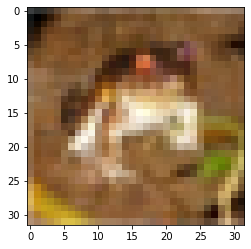

In [16]:
x_train, y_train, x_test, y_test = process_cifar_dataset()
c = ConvolutionLayer(10, 3, 1, 1)
img = x_train[0].reshape(3, 32, 32)
img = img.transpose(1, 2, 0)
plt.imshow(img)
o = c.forward(img)
print(o.shape)
o[:, :, 0]

In [17]:
o1 = m.forward(o)
o1[:, :, 0]

array([[ 1.3861713 ,  2.19163719,  3.87771698,  4.3926711 ,  4.32013074,
         4.05606504,  4.12924175,  4.18978392,  4.20873846,  4.17807422,
         4.49584662,  4.47882409,  4.61639432,  4.93633452,  4.86696006,
         4.51061115],
       [ 1.72701755,  3.11610216,  3.76934383,  3.96094987,  3.85945939,
         3.95433907,  4.00751499,  4.15983016,  3.96747851,  4.05414113,
         4.55627745,  4.62683946,  4.3204645 ,  4.45659864,  4.41330243,
         3.98601052],
       [ 2.91033126,  3.89535417,  4.07282703,  3.86513166,  3.94699492,
         3.9630778 ,  3.79746241,  3.8867337 ,  3.46213142,  3.75769031,
         4.15428655,  4.38199322,  4.58259961,  4.15830523,  3.47088407,
         2.57215249],
       [ 3.99420272,  4.25554452,  4.22668005,  4.09483726,  4.25660204,
         4.12249357,  3.13154672,  2.79604784,  4.80406471,  4.07397643,
         3.03374579,  4.08072891,  4.62556516,  4.50395415,  3.67333749,
         3.69734483],
       [ 5.24893582,  5.04232355,  4